In [1]:
from skimage import data, segmentation, filters, color, io
from skimage import graph
from matplotlib import pyplot as plt
from GraphGen.gen import nxgraph_to_adj_matrix, gen_properties
import numpy as np
import json
import os
import pickle

In [2]:
def weight_boundary(graph, src, dst, n):
    """
    Handle merging of nodes of a region boundary region adjacency graph.

    This function computes the `"weight"` and the count `"count"`
    attributes of the edge between `n` and the node formed after
    merging `src` and `dst`.


    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the "weight" and "count" attributes to be
        assigned for the merged node.

    """
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }


def merge_boundary(graph, src, dst):
    """Call back called before merging 2 nodes.

    In this case we don't need to do any computation here.
    """
    pass

def get_text(text_data, filename):
    classname = filename[:-8]
    for entry in text_data[classname]:
        if entry.get("filename") == filename:
            
            return entry

In [3]:
file = open('../datasets/NWPU-Captions/dataset_nwpu.json', 'r')
text_data = json.load(file)

In [ ]:
base_path = '../datasets/NWPU-Captions/NWPU_images/'
test_adjs = []
test_desc = []
train_adjs = []
train_desc = []
val_adjs = []
val_desc = []

train_properties = []
test_properties = []
val_properties = []

for classname in text_data:
    print("Current class: ", classname)
    class_path = os.path.join(base_path, classname)
    for entry in text_data[classname]:
        try:
            img = io.imread(os.path.join(class_path, entry['filename']))
        except:
            continue
        edges = filters.sobel(color.rgb2gray(img))
        labels = segmentation.slic(img, compactness=30, n_segments=400, start_label=1)
        g = graph.rag_boundary(labels, edges)

        labels2 = graph.merge_hierarchical(labels, g, thresh=0.08, rag_copy=False,
                                        in_place_merge=True,
                                        merge_func=merge_boundary,
                                        weight_func=weight_boundary)
        adj = nxgraph_to_adj_matrix(g)
        if entry['split'] == 'train':
            for i in range(5): train_adjs.append(adj)
            train_desc.append(entry['raw'])
            train_desc.append(entry['raw_1'])
            train_desc.append(entry['raw_2'])
            train_desc.append(entry['raw_3'])
            train_desc.append(entry['raw_4'])
        elif entry['split'] == 'test':
            for i in range(5): test_adjs.append(adj)
            test_desc.append(entry['raw'])
            test_desc.append(entry['raw_1'])
            test_desc.append(entry['raw_2'])
            test_desc.append(entry['raw_3'])
            test_desc.append(entry['raw_4'])
        else:
            for i in range(5): val_adjs.append(adj)
            val_desc.append(entry['raw'])
            val_desc.append(entry['raw_1'])
            val_desc.append(entry['raw_2'])
            val_desc.append(entry['raw_3'])
            val_desc.append(entry['raw_4'])

train_properties = gen_properties(train_adjs)
test_properties = gen_properties(test_adjs)
val_properties = gen_properties(val_adjs)

In [ ]:
with open(os.path.join('../datasets/NWPU-Captions/train', 'graphs.pkl'), 'wb') as f:
    pickle.dump(train_adjs, f)
with open(os.path.join('../datasets/NWPU-Captions/train', 'properties.pkl'), 'wb') as f:
    pickle.dump(train_properties, f)
with open(os.path.join('../datasets/NWPU-Captions/train', 'descriptions.pkl'), 'wb') as f:
    pickle.dump(train_desc, f)

with open(os.path.join('../datasets/NWPU-Captions/test', 'graphs.pkl'), 'wb') as f:
    pickle.dump(test_adjs, f)
with open(os.path.join('../datasets/NWPU-Captions/test', 'properties.pkl'), 'wb') as f:
    pickle.dump(test_properties, f)
with open(os.path.join('../datasets/NWPU-Captions/test', 'descriptions.pkl'), 'wb') as f:
    pickle.dump(test_desc, f)

with open(os.path.join('../datasets/NWPU-Captions/val', 'graphs.pkl'), 'wb') as f:
    pickle.dump(val_adjs, f)
with open(os.path.join('../datasets/NWPU-Captions/val', 'properties.pkl'), 'wb') as f:
    pickle.dump(val_properties, f)
with open(os.path.join('../datasets/NWPU-Captions/val', 'descriptions.pkl'), 'wb') as f:
    pickle.dump(val_desc, f)

In [26]:
img = io.imread('../datasets/NWPU-Captions/NWPU_images/airplane/airplane_621.jpg')
edges = filters.sobel(color.rgb2gray(img))
labels = segmentation.slic(img, compactness=30, n_segments=100, start_label=1)
g = graph.rag_boundary(labels, edges)

labels2 = graph.merge_hierarchical(labels, g, thresh=0.08, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)


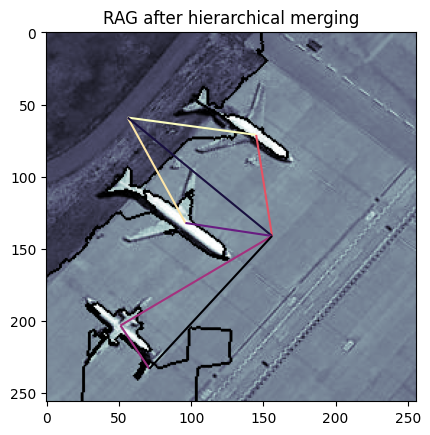

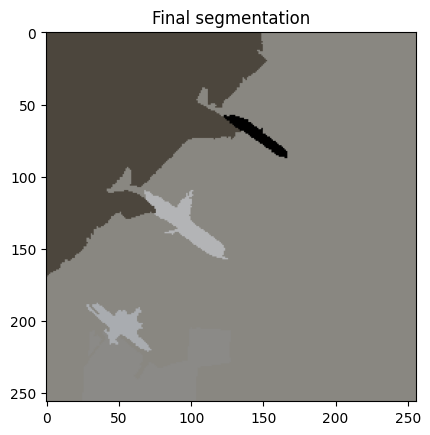

In [29]:
graph.show_rag(labels, g, img)
plt.title('RAG after hierarchical merging')

plt.figure()
out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
plt.imshow(out)
plt.title('Final segmentation')

plt.show()

In [28]:
g.number_of_nodes()

6